# exp0-4

* `논문에서와 정확히 똑같은 조건이 아니었는지, 오히려 그 전보다 validation 성능이 더욱 낮아짐...`<br>
  그래서 pytorch community에서 일반적으로 ResNet34를 학습시킬 때, 사용했던 preprocessing을 그대로 적용해봄.<br>
  결국 Experiment 1.~4.와 똑같은 조건인데, lr_sheduler가 제때 작용하도록 더욱 엄격하게 만듦것일 뿐.
   * `Experiment 6의 결과` : 
     결국 논문에서의 Top-1 error rate(21.84%)와 Top-5 error rate(5.71%)에 한참 못 미치는, <br>
     `Top-1 error rate(29.13%)와 Top-5 error rate(10.05%)`
     


# Training details

- The image is resized with its shorter side randomly sampled in [256, 480] for scale augmentation [41].
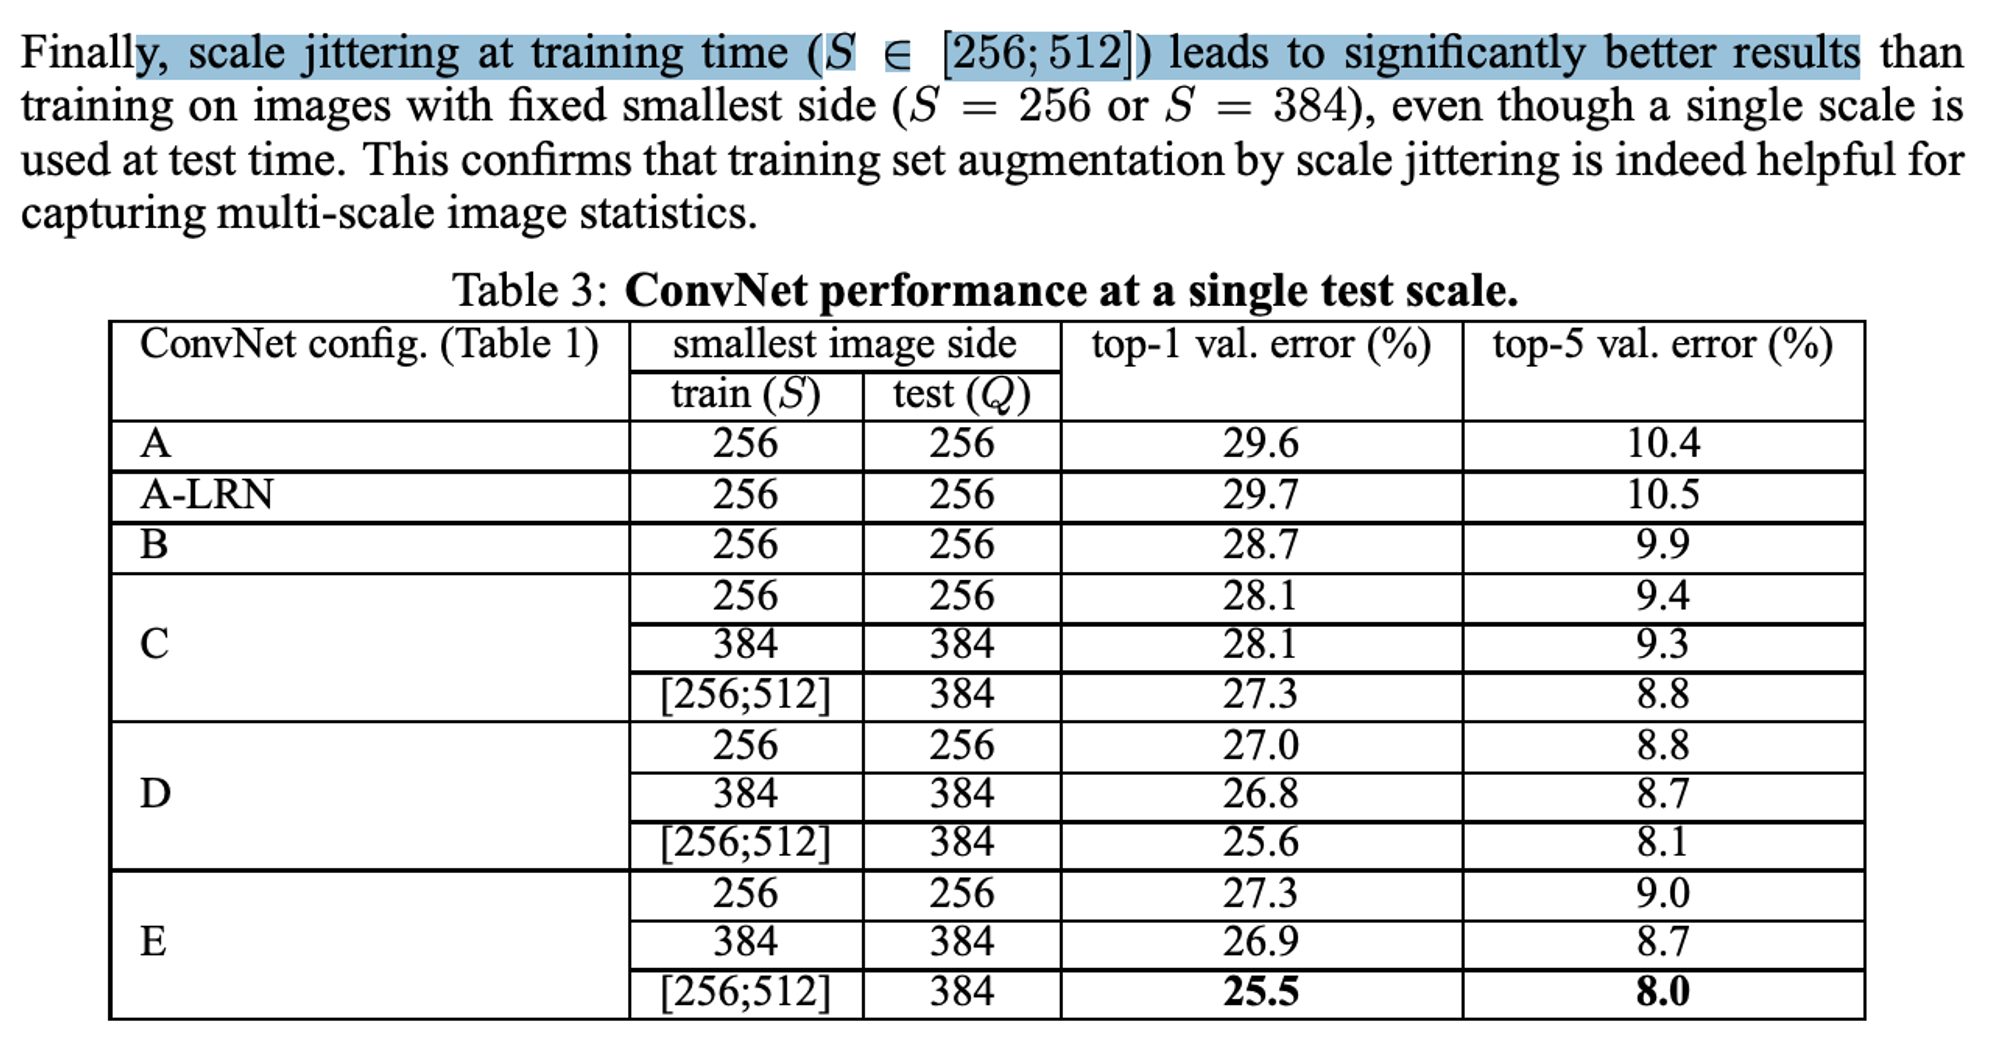
- A 224×224 crop is randomly sampled from an image or its
- horizontal flip, with the per-pixel mean subtracted [21].
- The standard color augmentation in [21] is used. 
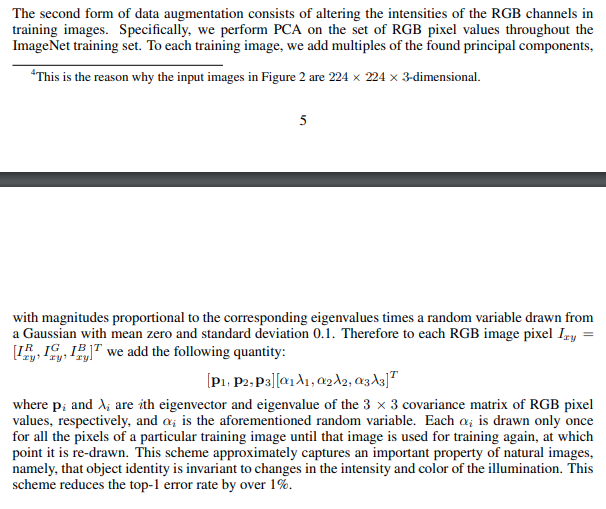
- We adopt batch normalization (BN) [16] right after each convolution and before activation, following [16]. 
- We initialize the weights as in [13] and train all plain/residual nets from scratch. 
- We use SGD with a mini-batch size of 256. 
- The learning rate starts from 0.1 and is divided by 10 when the error plateaus,
and the models are trained for up to 60 × 104 iterations. 
- We use a weight decay of 0.0001 and a momentum of 0.9.
- We do not use dropout

# Val/Test details 

- In testing, for comparison studies we adopt the standard 10-crop testing [21]. 
- For best results, we adopt the fullyconvolutional form as in [41, 13], and average the scores at multiple scales (images are resized such that the shorter side is in {224, 256, 384, 480, 640}).

In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL


2024-01-23 00:11:39.164856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 00:11:39.290670: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [15]:
class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = eigval
        self.eigvec = eigvec

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone()\
            .mul(alpha.view(1, 3).expand(3, 3))\
            .mul(self.eigval.view(1, 3).expand(3, 3))\
            .sum(1).squeeze()
        return img.add(rgb.view(3, 1, 1).expand_as(img))
    
__imagenet_pca = {
    'eigval': torch.Tensor([0.2175, 0.0188, 0.0045]),
    'eigvec': torch.Tensor([
        [-0.5675,  0.7192,  0.4009],
        [-0.5808, -0.0045, -0.8140],
        [-0.5836, -0.6948,  0.4203],
    ])
}

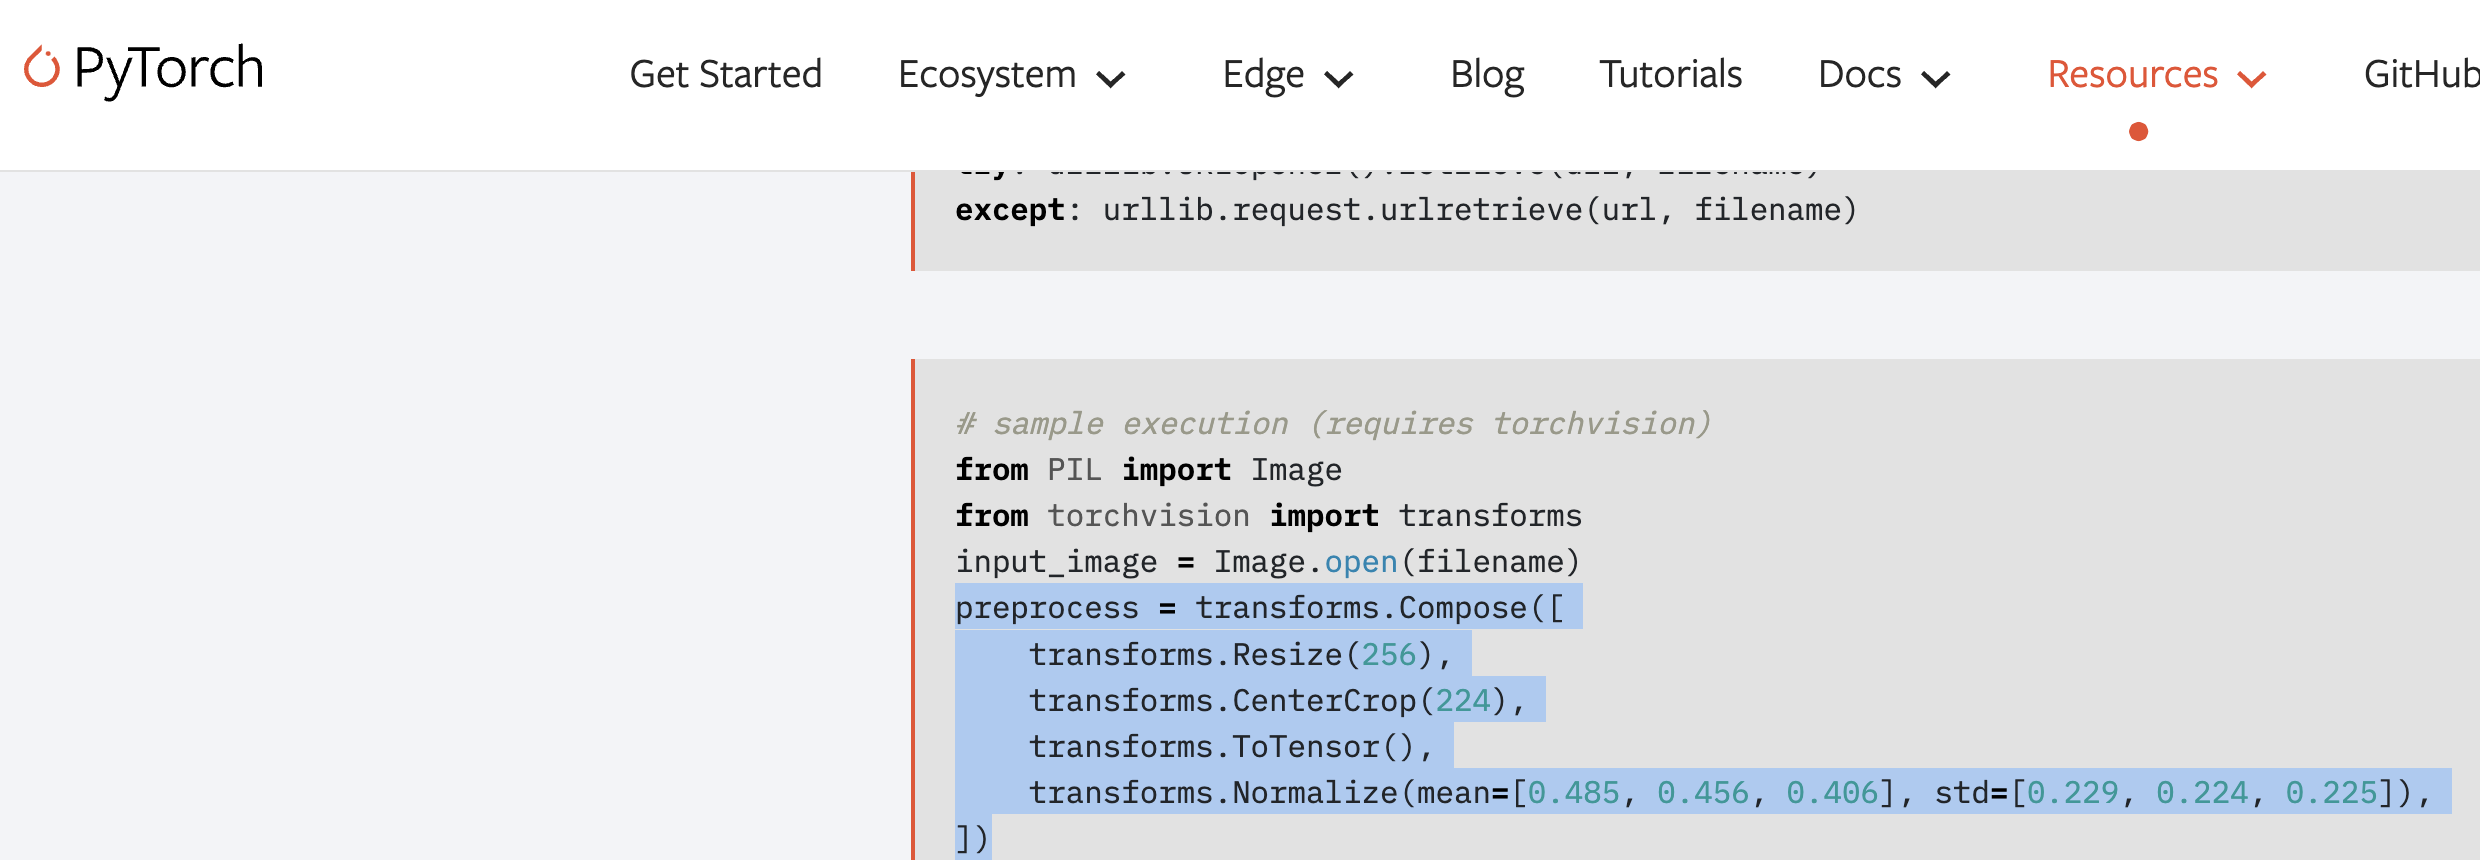

In [2]:
# X The image is resized with its shorter side randomly sampled in [256, 480] for scale augmentation [41].
# V A 224×224 crop is randomly sampled from an image or its horizontal flip, 
# V with the per-pixel mean subtracted [21].
# V The standard color augmentation in [21] is used. (Fancy PCA)
# - We adopt batch normalization (BN) [16] right after each convolution and before activation, following [16]. 
# - We initialize the weights as in [13] and train all plain/residual nets from scratch. 
# - We use SGD with a mini-batch size of 256. 
# - The learning rate starts from 0.1 and is divided by 10 when the error plateaus,
# and the models are trained for up to 60 × 10^4 iterations. 
# - We use a weight decay of 0.0001 and a momentum of 0.9.
# - We do not use dropout
trainset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train', 
    
    transform = transforms.Compose([   
        # transforms.RandomResizedCrop(size=(256, 480)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # Lighting(0.1, __imagenet_pca['eigval'], __imagenet_pca['eigvec']),
    ])
)

valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val',
    transform=transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [3]:
mini_batch_size = 256
# make trainloader
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

In [27]:
# mini_batch_size = 256
print(f"mini_batch_size : {mini_batch_size}")

num_train_examples = len(trainset)
num_val_examples = len(valset)
num_train_batch = len(train_loader) # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)

print(f"# train examples : {num_train_examples}")
print(f"# val examples : {num_val_examples}")
print(f"# train batches : {num_train_batch}")
print(f"# val batches : {num_val_batch}")

mini_batch_size : 256
# train examples : 1281167
# val examples : 50000
# train batches : 5005
# val batches : 196


In [28]:
# check the structure of train_loader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([256, 3, 224, 224])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

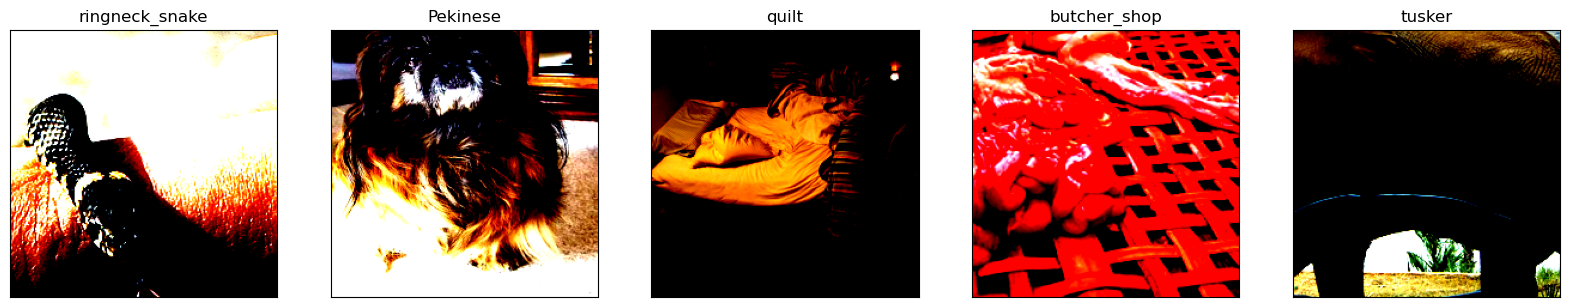

In [29]:
import random
import json

# 1000 classes
num_classes = 1000
with open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/imagenet_class_index.json') as f:
    class_index = json.load(f)
# Get the human-readable class names
class_names = [class_index[str(i)][1] for i in range(num_classes)]
# Print the class names
print(class_names)

writer = SummaryWriter('../runs/paper_resnet34_lr1e-01_experiment2')
# check random 5 examples of trainset
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    # record 5 examples of trainset to tensorboard
    writer.add_image(f"trainset_examples_{i}", image, label)
    

In [2]:
# training details

model = models.resnet34(pretrained=False, progress=True)
print(model.eval)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# he initialization, not use bias
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.fill_(1)

model.apply(init_weights)

/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hslee/anaconda3/envs/DL/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<bound method Module.eval of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# hyper parameters
## learning rate
lr = 0.1
## momentum
momentum = 0.9
## weight decay
L2 = 0.0001
# the number of iterations at 1 epoch
num_iters = (len(trainset) // mini_batch_size) + 1
# the number of epochs
epochs = 120
print(f"num_iters at 1 epoch: {num_iters}")
total_num_iters = num_iters * epochs
print(f"total num_iters: {total_num_iters}")

## optimizer
## scheduler
## loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=L2)        

## if val loss plateaus, lr decay
lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True, threshold=0.01)  # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

NameError: name 'trainset' is not defined

In [32]:
# check # of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"# of total parameters : {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"# of trainable parameters : {total_trainable_params}")

# of total parameters : 21797672
# of trainable parameters : 21797672


In [33]:
# record model to tensorboard
# Assuming 'device' is defined as torch.device("cuda") or "cuda:0"
input_tensor = trainset[0][0].unsqueeze(0).to(device)
writer.add_graph(model, input_tensor)

In [34]:
# for visualization, record training loss and val loss
train_loss_list = []
val_loss_list = []

# accuracy
val_acc_list = []

In [35]:
import time
# Start measuring time
start_time = time.time()

# ------------------------------------------------------------------------------------------------------------------------------

# training no pretrained resnet34 model with GPU
model.train().to(device)
for epoch in range(0, epochs):
            
    running_loss = 0.0
    print(f"{epoch+1} / {epochs} epoch ----------------------------------------")
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # every 1,000 iteration
        running_loss += loss.item()
        if i % 1000 == 999:
            print(f"[{i+1}th iteration] loss : {running_loss / 1000}")
            writer.add_scalar('training loss', running_loss / 1000, epoch * num_iters + i)
            running_loss = 0.0
            
    # every epoch
    # validation loss, accuracy
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print(f"val loss : {val_loss / num_val_batch}")
    print(f"val acc : {100. * correct / total}")
    writer.add_scalar('validation loss', val_loss / num_val_batch, epoch+1)
    writer.add_scalar('validation acc', 100. * correct / total, epoch+1)
    writer.flush()
    # if error plateaus, lr decay. record lr to tensorboard
    lr_scheduler.step(val_loss / num_val_batch)
    writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch+1)
    val_loss_list.append(val_loss / num_val_batch)
    val_acc_list.append(100. * correct / total)
            
    
    # checkpoint
    PATH = f"./Paper_ResNet34_exp0-4_Checkpoint/epoch_{epoch+1}.pth"
    torch.save(model.state_dict(), PATH)
    # save best model (minimum val loss)
    if val_loss / num_val_batch == min(val_loss_list):
        PATH = f"./Paper_ResNet34_exp0-4_Checkpoint/best_model.pth"
        torch.save(model.state_dict(), PATH)
    
    
# ------------------------------------------------------------------------------- -----------------------------------------------        
        
# End measuring time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

1 / 120 epoch ----------------------------------------
[1000th iteration] loss : 6.415653609752655
[2000th iteration] loss : 5.511911385059356
[3000th iteration] loss : 4.958374750614166
[4000th iteration] loss : 4.505976203680039
[5000th iteration] loss : 4.172450695037842
val loss : 3.749841086718501
val acc : 22.68


RuntimeError: Parent directory ./Paper_ResNet34_lr1e-01_experiment2_Checkpoint does not exist.

# In Paper, top-1 error., top-5 error. (10-crop)
- `top-1 error.` : 75.48 %
- `top-5 error.` : 92.54 %

In [2]:
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val',
    transform=transforms.Compose([
        # 10-crop
        transforms.Resize(256),
        # transforms.Resize((256 + 480) // 2),
        transforms.TenCrop(224),    
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [9]:
mini_batch_size = 64

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=8, pin_memory=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)
print(f"num_val_batch : {num_val_batch}")

num_val_batch : 782


In [8]:
# best model에 대한 top-1 accuracy 계산
model = models.resnet34(pretrained=False, progress=True)
model.load_state_dict(torch.load("./Paper_ResNet34_exp0-4_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()


NameError: name 'num_val_batch' is not defined

In [11]:
print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")

val loss : 1.0745586658377781
val acc : 73.016%
error rate : 26.984%


In [13]:
# best model에 대한 top-5 accuracy 계산, TenCrop
model = models.resnet34(pretrained=False, progress=True)
model.load_state_dict(torch.load("./Paper_ResNet34_exp0-4_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.topk(5, 1, True, True)
        total += target.size(0)
        correct += predicted.eq(target.view(-1, 1).expand_as(predicted)).sum().item()     

print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")

val loss : 1.0745553976434576
val acc : 91.316%
error rate : 8.684%
